In [2]:
%pip install -q langgraph==0.3.31 
%pip install -q langchain-ibm==0.3.10
%pip install -q langchain==0.3.23
%pip install -q langchain_community==0.3.21 
%pip install -q pygraphviz==1.14

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
from langchain_ibm import ChatWatsonx
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import MessageGraph, StateGraph

from typing import List, Sequence
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

In [4]:
llm = ChatWatsonx(
    model_id="ibm/granite-3-3-8b-instruct",
    url="https://us-south.ml.cloud.ibm.com",
    project_id="skills-network"
)

In [5]:
generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
             "system",
            "You are a professional LinkedIn content assistant tasked with crafting engaging, insightful, and well-structured LinkedIn posts."
            " Generate the best LinkedIn post possible for the user's request."
            " If the user provides feedback or critique, respond with a refined version of your previous attempts, improving clarity, tone, or engagement as needed.",  
        ),
        MessagesPlaceholder(variable_name="messages")
    ]
)
    

In [6]:
generate_chain= generation_prompt | llm

In [7]:
reflection_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are a professional LinkedIn content strategist and thought leadership expert. Your task is to critically evaluate the given LinkedIn post and provide a comprehensive critique. Follow these guidelines:

        1. Assess the post’s overall quality, professionalism, and alignment with LinkedIn best practices.
        2. Evaluate the structure, tone, clarity, and readability of the post.
        3. Analyze the post’s potential for engagement (likes, comments, shares) and its effectiveness in building professional credibility.
        4. Consider the post’s relevance to the author’s industry, audience, or current trends.
        5. Examine the use of formatting (e.g., line breaks, bullet points), hashtags, mentions, and media (if any).
        6. Evaluate the effectiveness of any call-to-action or takeaway.

        Provide a detailed critique that includes:
        - A brief explanation of the post’s strengths and weaknesses.
        - Specific areas that could be improved.
        - Actionable suggestions for enhancing clarity, engagement, and professionalism.

        Your critique will be used to improve the post in the next revision step, so ensure your feedback is thoughtful, constructive, and practical.
        """
    ),
    MessagesPlaceholder(variable_name="messages")
])

In [8]:
reflect_chain = reflection_prompt | llm

In [9]:
from typing import List, Annotated, TypedDict
from langchain.schema import HumanMessage, AIMessage, SystemMessage

In [10]:
class agent_state(TypedDict):
    messages: Annotated[list[HumanMessage| AIMessage| SystemMessage], " add_messages"]
    

In [11]:
from langgraph.graph import END
graph=MessageGraph()

In [12]:
def generate_node ( state : Sequence[BaseMessage]) -> List[BaseMessage]:
    generate_post= generate_chain.invoke({ "messages": state })
    return [ AIMessage(content = generate_post.content)]
    

In [13]:
def reflection_node(messages: Sequence[BaseMessage]) -> List[BaseMessage]:
    res = reflect_chain.invoke({"messages": messages})  # Passes messages as input to reflect_chain
    return [HumanMessage(content=res.content)]  # Returns the refined message as HumanMessage for feedback
    

In [14]:
graph.add_node("generate", generate_node)

In [15]:
graph.add_node("reflect", reflection_node)

In [16]:
graph.add_edge("reflect", "generate")


In [17]:
graph.set_entry_point("generate")

In [18]:
def should_continue(state: List[BaseMessage]):
    print(state)
    print(len(state))
    print("----------------------------------------------------------------------")
    if len(state) > 6:
        return END
    return "reflect"
    

In [19]:
graph.add_conditional_edges("generate", should_continue)

In [20]:
workflow = graph.compile()

In [21]:
inputs = HumanMessage(content="""Write a linkedin post on getting a software developer job at IBM under 160 characters""")

In [27]:
print(response = workflow.invoke(inputs))

[HumanMessage(content='Write a linkedin post on getting a software developer job at IBM under 160 characters', additional_kwargs={}, response_metadata={}, id='881191b4-1472-4218-9c43-ff1019b90a39'), AIMessage(content="🎉Thrilled to announce that I've joined IBM as a Software Developer! Honored to contribute to innovative projects and collaborate with tech giants. Eager to learn and grow with such a prestigious company. #IBM #SoftwareDevelopment #NewJob #CareerProgression", additional_kwargs={}, response_metadata={}, id='4045b7bf-3bd5-4b85-a203-573b52c8f241')]
2
----------------------------------------------------------------------
[HumanMessage(content='Write a linkedin post on getting a software developer job at IBM under 160 characters', additional_kwargs={}, response_metadata={}, id='881191b4-1472-4218-9c43-ff1019b90a39'), AIMessage(content="🎉Thrilled to announce that I've joined IBM as a Software Developer! Honored to contribute to innovative projects and collaborate with tech giant

TypeError: 'response' is an invalid keyword argument for print()

In [23]:
print(response[1].content)

🎉 Beyond words, I am thrilled to announce my new role as a Software Developer at IBM! I'm excited to contribute to innovative projects and learn from industry leaders. Grateful for the opportunity! #NewJob #SoftwareDevelopment #IBM

(Note: This post is intentionally concise to fit within LinkedIn's character limit)


In [24]:
print(response[2].content)

Critique:

Strengths:
1. Professional Tone: The post maintains a formal, appreciative tone appropriate for LinkedIn, conveying gratitude and excitement for the new opportunity.
2. Relevance: The post clearly identifies the author's new role and company, keeping it pertinent to their professional profile and industry.
3. Hashtags: The chosen hashtags (e.g., #NewJob, #SoftwareDevelopment, #IBM) align with LinkedIn best practices, making it more discoverable and enhancing visibility among professionals in the same industry.
4. Brevity: The post effectively communicates the news within the 160-character limit, a crucial aspect given the constraint.

Weaknesses:
1. Limited Engagement: Being terse, the post doesn't offer much for viewers to react to, potentially limiting engagement like comments, reactions, or shares.
2. No Insight or Value: The post merely announces the job change without sharing any insights, thought leadership, or lessons learned.
3. Missed Call-to-Action: The post lacks 

In [25]:
print(response[-1].content)

🚀 Navigating from aspiration to reality as a #SoftwareDeveloper at @IBM! Embracing #AI's power taught me the value of perseverance & continuous learning. Connect to share your journeys & let's inspire each other's growth! #NewChapter #TechJourney

(Final refined post incorporates a captivating hook, "Navigating from aspiration to reality," and delivers a significant takeaway about perseverance and continuous learning in software development, while adhering to LinkedIn's 160-character limit.)


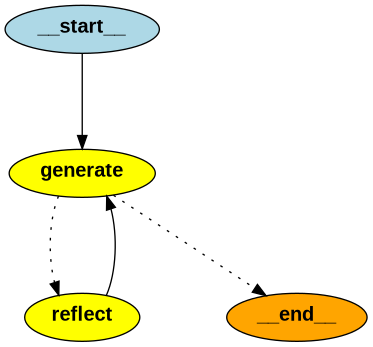

In [26]:
from IPython.display import Image, display

display(Image(workflow.get_graph().draw_png()))